# Informal Settlements

# 1_Training Notebook

In this notebook is done the model training. Is a convolutional neural network CNN with U-Net architecture. It needs a dataset with images and masks to train. These last ones are binary images that delimited the interest object with pixel values equal to 1 where the interest object is and 0 where it isn't.


In [ ]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator
import os
import matplotlib.pyplot as plt
import subprocess
import matplotlib.pyplot as plt

### **Variables statement**

In [6]:
#General
YEAR = "2021"
ZONE = "sula"
RESO = "low"

#Buckets
BUCKET_IMG_TRAIN = f"gs://dym-quilmes-trucks-temp/I2UD/imagenes/{ZONE}/{RESO}/{YEAR}/*.tif" 
BUCKET_GT= 'gs://dym-quilmes-trucks-temp/I2UD/asentamientos_informales/data/shp/gt/annotations_lowresolution_small_4326.geojson'

#Paths
BASE_PATH = "./.."
PATH_TRAIN_IMAGES = f'/images/{ZONE}/{RESO}/{YEAR}/'

In [10]:
if ZONE == "sula":

    SIZE =130
    STEP_SIZE = 40
    #satproc
    GT_FILE = "anotaciones_sula_final_4326.geojson" 
    CLASSES = 'A'
    #train
    INFO = "classA"
    #unet
    INPUT_SIZE=160
    CLASS_WEIGHT = [1]
    STEP_PER_EPOCH = 100
    N_CHANNELS=3
    N_CLASSES = 1
    VERSION='final' #planet
    MODEL_NAME= f'UNet_{ZONE}_{RESO}_{INPUT_SIZE}x{INPUT_SIZE}_{str(SIZE)}_{str(STEP_SIZE)}_spe{str(STEP_PER_EPOCH)}_fecha{YEAR}_{INFO}_{VERSION}.h5'

if ZONE == "tegu":

    SIZE =256
    STEP_SIZE = 50
    #satproc
    GT_FILE = "annotations_lowresolution_small_4326.geojson"
    CLASSES = "'A' 'B' 'C'"
    ##train
    INFO = "classABC"
    ##unet
    N_CHANNELS=8
    CLASS_WEIGHT = [0.2,0.3,0.5]
    STEP_PER_EPOCH = 95
    N_CLASSES = 3
    VERSION='v2'
    MODEL_NAME = f'UNet_{ZONE}_{RESO}_{INPUT_SIZE}x{INPUT_SIZE}_{str(SIZE)}_{str(STEP_SIZE)}_spe{str(STEP_PER_EPOCH)}_fecha{YEAR}_{INFO}_{VERSION}.h5'

if RESO =="low":
    
    RESCALE_MODE = "s2_rgb_extra --lower-cut 0 --upper-cut 100"
if RESO =="planet":
    
    RESCALE_MODE="percentiles --lower-cut 0 --upper-cut 100"

## Download from buckets

**Ground truth download**

In [5]:
data_folder= BASE_PATH + f'/data/{ZONE}/{RESO}/shp/gt'
!mkdir -p $data_folder

!gsutil -m cp -r $BUCKET_GT   $data_folder

Copying gs://dym-quilmes-trucks-temp/I2UD/asentamientos_informales/data/shp/gt/annotations_lowresolution_small_4326.geojson...
/ [1/1 files][103.2 KiB/103.2 KiB] 100% Done                                    
Operation completed over 1 objects/103.2 KiB.                                    


**Images download**

In [15]:
folder = BASE_PATH + PATH_TRAIN_IMAGES
!mkdir -p $folder

!gsutil -m cp -r $BUCKET_IMG_TRAIN   $folder

Copying gs://dym-quilmes-trucks-temp/I2UD/imagenes/tegu/low/2020/0000000000-0000000000.tif...
- [1/1 files][ 42.3 MiB/ 42.3 MiB] 100% Done                                    
Operation completed over 1 objects/42.3 MiB.                                     


**Tegucigalpa aoi download**

In [9]:
BUCKET_AOI='gs://dym-quilmes-trucks-temp/I2UD/asentamientos_informales/data/shp/aoi_train_tegu_4326.geojson'
aoi_folder= BASE_PATH + f'/data/{ZONE}/{RESO}/shp/'


!gsutil -m cp -r $BUCKET_AOI   $aoi_folder

Copying gs://dym-quilmes-trucks-temp/I2UD/asentamientos_informales/data/shp/aoi_train_tegu_4326.geojson...
/ [1/1 files][  677.0 B/  677.0 B] 100% Done                                    
Operation completed over 1 objects/677.0 B.                                      


 ## Training dataset generation

 In this stage the training dataset is generated using Satproc. This tool generates the dataset with characteristics needed for the model: size, number of images, value range, etc.

### Satproc

*Satproc_extract_chips* tool takes the image and the vector file with the annotations and generates a directory with two folders: "images" and "extent".Files in the first one are Tiff files with 3-bands (RGB). Also, files from the second folder are Tiff type but with N-bands, where N is the number of classes. Each band is a binary image. 

Observation: images and the vector file (gt) should have the same georeference, for instance, EPSG:4326

In [7]:
path_to_files= f'{BASE_PATH}{PATH_TRAIN_IMAGES}*.tif' #image folder
output_folder=os.path.join('./../dataset/data_train/',ZONE,RESO,YEAR,VERSION,str(SIZE)+'_'+str(STEP_SIZE)+'/')  #training dataset folder
vector_file = f'{BASE_PATH}/data/{ZONE}/{RESO}/shp/gt/{GT_FILE}' # gt vector file
#vector_file_aoi = f'{BASE_PATH}/data/{ZONE}/{RESO}/shp/aoi_train_tegu_4326.geojson' #aoi vector file

In [8]:
print(path_to_files,output_folder,vector_file,vector_file_aoi)

./../images/sula/low/2021/*.tif ./../dataset/data_train/sula/low/2021/final/130_40/ ./../data/sula/low/shp/gt/anotaciones_sula_final_4326.geojson ./../data/sula/low/shp/gt/anotaciones_sula_final_4326.geojson


Satproc execution

In [7]:
#!satproc_extract_chips --help


In [9]:
!satproc_extract_chips \
                $path_to_files \
                -o $output_folder \
                --size $SIZE \
                --step-size $STEP_SIZE \
                --aoi $vector_file \
                --labels $vector_file \
                --label-property 'CLASS' \
                --classes 'A' \
                --rescale \
                --rescale-mode $RESCALE_MODE

Rasters: 100%|###################################| 1/1 [02:19<00:00, 139.59s/it]


In [21]:
ls ./../dataset/data_train/tegu/planet/2022/final_model_2/256_50/images | wc -l

1388


**Arguments:**
* **path_to_files:** Images path

* **o:** Destination path

We recommend use a descriptive path. For instances: "./../datatrain/120_40/" describes: data_train → data use for train; 120_40 → < image size >< step size >.

* **size:** Chips size (chips are square images)
* **step-size:** Process step size. It should be less or equal to 'size'. If it's equal to size, there isn't an overlap in the resulting images
Sometimes, it's useful generating overlaping images for the training, because the overlaping increase the number of images in the training dataset.

* **label-property:** Field name where the classes are defined (it's only used for training dataset).

* **classes:** Classes names (as they appear in the geojson file), separated by spaces

* **labels:** Vector fil with ground truth annotations

* **aoi:** aoi file path. When an area of interest is stablished, Satproc only process that area of the image and the annotations inside it

* **rescale:** Rescale band values to 0-255


## Training run

We train the model using the datasets (images and masks) created with Satproc from which the model learn about the patterns that defines the object of interest.

In this stage, we define the model configuration.

**Obs:** It's useful named the model using information about training parameters. For instance: < model >< proyect >< images_dimension >< size >< step_size >_< step_per_epoch >.h5 or similar.

In [14]:
config = TrainConfig(width   = INPUT_SIZE,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc; y no menor a 80)
                     height  = INPUT_SIZE,
                     n_channels   = N_CHANNELS,  #  número de canales de la imagen, rgb -> 3
                     n_classes    = N_CLASSES, # número de clases a clasificar
                     apply_image_augmentation = True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes (rotación,)
                     seed       = 42,
                     epochs     = 20, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size = 16, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch  = STEP_PER_EPOCH, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience  = 8, # a medida que entrena se guardan los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 10  iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split   = 0.1, # se divide la muestra en training (80% de los datos) y validation (20% de los datos) para calcular el error durante el proceso de entrenamiento
                     test_split         = 0.1, # Cantidad de imágenes del dataset
                     images_path        = output_folder,#ruta a las imágenes generadas con Satproc
                     model_path         = os.path.join(BASE_PATH,'data/weights/', MODEL_NAME),#  ruta del modelo entrenado
                     model_architecture = 'unet',
                     evaluate           = True  ,
                     class_weights      = CLASS_WEIGHT) 

We can visualize some images and masks from the training dataset. (Left: image, Right: mask.)

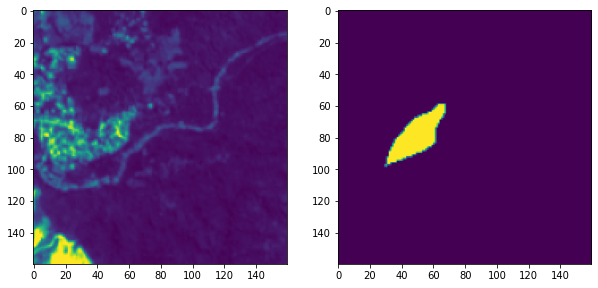

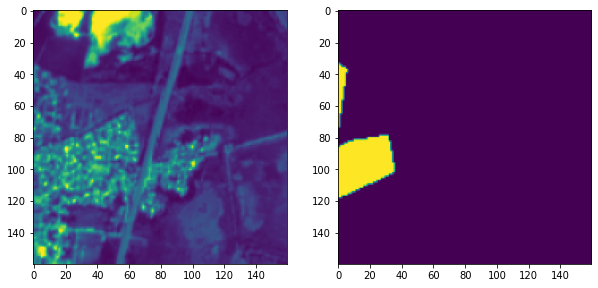

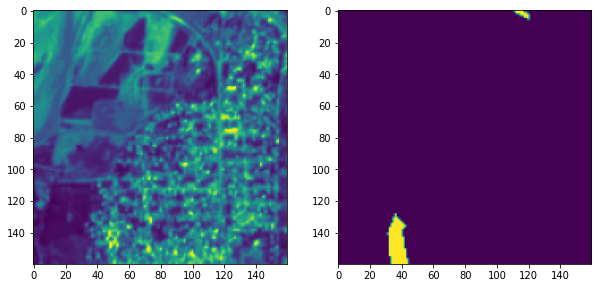

In [16]:
plot_data_generator(num_samples=3, fig_size=(10,10), train_config=config,img_ch =3)

Running the training process.

In [17]:
res_config = train(config)

2022-11-08 17:42:30.710761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-08 17:42:30.710790: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-08 17:42:30.710811: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (59pd87v5dv4ce8um): /proc/driver/nvidia/version does not exist
2022-11-08 17:42:30.711284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropr

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

Plotting the metrics.

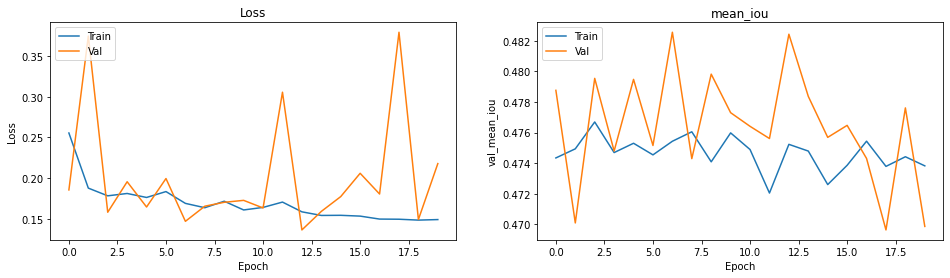

In [19]:
plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_io_u'])
plt.plot(res_config.history['val_mean_io_u'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()
